In [44]:
import os
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
from torchvision.io import read_image
import glob
import torchvision

In [45]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform = None, target_transform = None):
        tmp = pd.read_csv(annotations_file)[['Id', 'Pawpularity']]
        
        self.img_labels = tmp
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0] + '.jpg')
        image = read_image(img_path)
        label = torch.tensor(np.float32(self.img_labels.iloc[idx, 1]))
        t = torchvision.transforms.ToPILImage()
        image = t(image)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image.float(), label

In [46]:
from deepml import constants
transforms = torchvision.transforms.Compose([
                                              torchvision.transforms.ToTensor(), torchvision.transforms.Resize((224, 224))])

pd.read_csv(r'C:\Users\Andrew\Downloads\petfinder-pawpularity-score\train.csv')[['Id', 'Pawpularity']]

,Id,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,63
1,0009c66b9439883ba2750fb825e1d7db,42
2,0013fd999caf9a3efe1352ca1b0d937e,28
3,0018df346ac9c1d8413cfcc888ca8246,15
4,001dc955e10590d3ca4673f034feeef2,72
...,...,...
9907,ffbfa0383c34dc513c95560d6e1fdb57,15
9908,ffcc8532d76436fc79e50eb2e5238e45,70
9909,ffdf2e8673a1da6fb80342fa3b119a20,20
9910,fff19e2ce11718548fa1c5d039a5192a,20


In [47]:
import deepml
model = torchvision.models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(in_features=512, out_features=1, bias=True)
from deepml.tasks import ImageRegression
from deepml.train import Learner
from deepml.losses import RMSELoss

work_dir = 'resnet18'
regression = ImageRegression(model, work_dir)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = RMSELoss()

learner = Learner(regression, optimizer, criterion)

full_dataset = CustomImageDataset(r'C:\Users\Andrew\Downloads\petfinder-pawpularity-score\train.csv', r'C:\Users\Andrew\Downloads\petfinder-pawpularity-score\train', transforms)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])


C:\Users\Andrew\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\Andrew\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


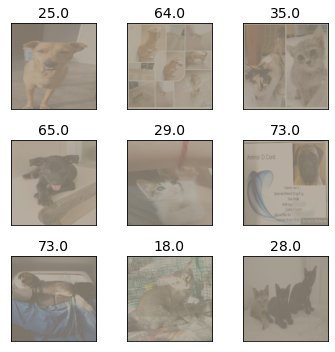

In [48]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)
from deepml.visualize import show_images_from_loader
from deepml.transforms import ImageNetInverseTransform

inverse_transform = ImageNetInverseTransform()
show_images_from_loader(val_loader, inverse_transform)

In [20]:
from torch.nn import MSELoss

# metrics to evaluate 
metrics = [("mse", MSELoss())]

# Here, we are passing inverse transform to see those images on tensorboard
learner.fit(train_loader, val_loader, epochs=3, image_inverse_transform=inverse_transform,
            metrics=metrics)

Epoch 1/3:


Training    :   0%|          | 0/992 [00:00<?, ?it/s]

Validation  :   0%|          | 0/248 [00:00<?, ?it/s]

Training Loss: 24.0612 Validation Loss: 18.8090 [Saving best validation model]
Epoch 2/3:


Training    :   0%|          | 0/992 [00:00<?, ?it/s]

Validation  :   0%|          | 0/248 [00:00<?, ?it/s]

Training Loss: 17.8862 Validation Loss: 18.6107 [Saving best validation model]
Epoch 3/3:


Training    :   0%|          | 0/992 [00:00<?, ?it/s]

Validation  :   0%|          | 0/248 [00:00<?, ?it/s]

Training Loss: 16.3888 Validation Loss: 19.2146 


In [21]:
learner.save('current_model.pt', save_optimizer_state=True, epoch=7)

'resnet18\\current_model.pt'

In [27]:
from deepml.datasets import ImageListDataset
test_dir = r'C:\Users\Andrew\Downloads\petfinder-pawpularity-score\mytest'
test_dataset = ImageListDataset(test_dir, transforms)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, num_workers=4)
test_predictions, filenames = learner.predict(test_loader)

Prediction  :   0%|          | 0/3 [00:00<?, ?it/s]

In [35]:
submission = pd.DataFrame(columns=['Id', 'Pawpularity'])
submission['Pawpularity'] = np.squeeze(test_predictions.numpy())
submission['Id'] = [i.split('.')[0] for i in filenames]



In [36]:
submission.to_csv(r'C:\Users\Andrew\Downloads\petfinder-pawpularity-score\mytest\submission.csv', index=False)

In [41]:
torch.save(model, r'1.pb')

In [50]:
model = torch.load(r'1.pb')
work_dir = 'resnet18'
regression = ImageRegression(model, work_dir)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = RMSELoss()

learner = Learner(regression, optimizer, criterion)


In [57]:
image = torchvision.io.read_image(r'C:\Users\Andrew\Downloads\petfinder-pawpularity-score\mytest\2.jpg')
t = torchvision.transforms.ToPILImage()
image = t(image)
image = transforms(image)
image = image.float().unsqueeze(0)
model.eval()
y = model(image.cuda())

In [58]:
print(y)

tensor([[74.9995]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [43]:
submission = pd.DataFrame(columns=['Id', 'Pawpularity'])
submission['Pawpularity'] = np.squeeze(test_predictions.numpy())
submission['Id'] = [i.split('.')[0] for i in filenames]
submission.to_csv(r'C:\Users\Andrew\Downloads\petfinder-pawpularity-score\mytest\submission.csv', index=False)